In [281]:
# import helper
import pandas as pd
from utils import *
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
from IPython.display import Image
import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [282]:
tf.random.set_seed(15)
torch.manual_seed(42)
random.seed(42)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Data : We use the same data as used on Classical solutions

In [283]:
df = pd.read_csv('Processed_data_till_7_march.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
# Initial dataframe has few rows which has zeros for features like "SMA_7" etc and hence removing few top rows
df=df[50:]
# Remove few redundant data
df=df.drop(columns=['Date'])
df=df.drop(columns=['CUMLOGRET_1'])
df=df.drop(columns=['Gold in USD volume'])
df=df.drop(columns=['Open'])
df=df.drop(columns=['High'])
df=df.drop(columns=['Low'])

In [284]:
# Set target and features
target = "Close"
features = list(df.columns.difference(["Close"]))
print(features)
print(len(features))

['3M', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'Close_copy', 'Crude Futures_close', 'Crude Futures_volume', 'Crude_H-L', 'Crude_O-C', 'EMA_14', 'EMA_21', 'EMA_7', 'FTSE_H-L', 'FTSE_O-C', 'GBP USD ', 'GBP_USD_H-L', 'GBP_USD_O-C', 'Gold in USD close', 'Gold_H-L', 'Gold_O-C', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_14', 'SMA_21', 'SMA_7', 'Volume']
29


In [285]:
# close_min=min(df['Close'].values)
# close_max=max(df['Close'].values)
# a=-1
# b=1
# normalized_df_2=(b-a)*((df-df.min())/(df.max()-df.min()))+a

In [286]:
target_mean = df[target].mean()
target_stdev = df[target].std()

mean=dict()
stdev=dict()
for c in df.columns:
    mean[c] = df[c].mean()
    stdev[c] = df[c].std()

    df[c] = (df[c] - mean[c]) / stdev[c]

In [287]:
# df['Close']=normalized_df_2['Close']

In [288]:
sequence_length = 60
window =6

def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,3):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return np.array(X_store), np.array(y_store)

In [289]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df))-6
df_train=df[:size]
df_test=df[size:]
print('Total sample', len(df))
print('Train sample', len(df_train))
print('Test sample', len(df_test))

Total sample 3212
Train sample 3206
Test sample 6


In [290]:
# Train data
X_train, y_train = create_dataset(
    df_train,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

indices = tf.range(start=0, limit=tf.shape(X_train)[0])
shuffled_indices = tf.random.shuffle(indices)
X_train = tf.gather(X_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

print(X_train.shape, y_train.shape)

(1047, 60, 29) (1047, 6)


In [291]:
X_check=(df_train[features].values)[len(df_train)-sequence_length:len(df_train)]
y_check=(df_test[target].values)[:window]

# Proposed Approach

In [292]:
from tensorflow.keras import regularizers, initializers
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model
from keras.layers.advanced_activations import PReLU
import tensorflow as tf

In [293]:
input_ = Input((60,29)) # feature
print(input_.shape)
den1=Dense(20, use_bias=True,activation=PReLU() )(input_)
print(den1.shape)
den2=Flatten()(den1)
print(den2.shape)
den3=Dense(64, use_bias=True,activation=PReLU()  )(den2)
print(den3.shape)
den4=Dense(32, use_bias=True,activation=PReLU()  )(den3)
print(den4.shape)
den5=Dense(6, use_bias=True,activation=PReLU() )(den4)
print(den5.shape)
model = Model(inputs=[input_], outputs=den5)

(None, 60, 29)
(None, 60, 20)
(None, 1200)
(None, 64)
(None, 32)
(None, 6)


In [294]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 60, 29)]          0         
                                                                 
 dense_48 (Dense)            (None, 60, 20)            1800      
                                                                 
 flatten_12 (Flatten)        (None, 1200)              0         
                                                                 
 dense_49 (Dense)            (None, 64)                76928     
                                                                 
 dense_50 (Dense)            (None, 32)                2112      
                                                                 
 dense_51 (Dense)            (None, 6)                 204       
                                                                 
Total params: 81,044
Trainable params: 81,044
Non-trainabl

In [295]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss=loss_fn)

In [296]:
model_history = model.fit(X_train, y_train,
                   batch_size=5, 
                   epochs=400, shuffle=True
                   )

Epoch 1/400
210/210 [==============================] - 2s 2ms/step - loss: 0.2825
Epoch 2/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0706
Epoch 3/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0462
Epoch 4/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0368
Epoch 5/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 6/400
210/210 [==============================] - 1s 2ms/step - loss: 0.0254
Epoch 7/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 8/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0195
Epoch 9/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 10/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 11/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 12/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 13/400


210/210 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 197/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 198/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 199/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 200/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 201/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 202/400
210/210 [==============================] - 1s 3ms/step - loss: 9.6459e-04
Epoch 203/400
210/210 [==============================] - 1s 3ms/step - loss: 7.6027e-04A: 0s - loss:
Epoch 204/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 205/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 206/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 207/400
210/210 [==============================] - 1s 2ms/step 

210/210 [==============================] - 0s 2ms/step - loss: 6.7925e-04
Epoch 388/400
210/210 [==============================] - 1s 3ms/step - loss: 5.9104e-04
Epoch 389/400
210/210 [==============================] - 0s 2ms/step - loss: 5.5414e-04
Epoch 390/400
210/210 [==============================] - 0s 2ms/step - loss: 7.7010e-04
Epoch 391/400
210/210 [==============================] - 0s 2ms/step - loss: 7.9096e-04
Epoch 392/400
210/210 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 393/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 394/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0014
Epoch 395/400
210/210 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 396/400
210/210 [==============================] - 0s 2ms/step - loss: 9.1488e-04
Epoch 397/400
210/210 [==============================] - 0s 2ms/step - loss: 6.5368e-04
Epoch 398/400
210/210 [==============================] - 0s 2m

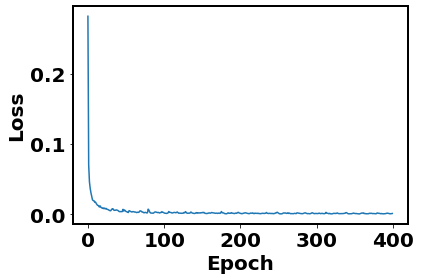

In [297]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [298]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=((((y_true[i]-a)/(b-a))*(close_max - close_min))+close_min)
        y2=((((y_pred[i]-a)/(b-a))*(close_max - close_min))+close_min)
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [299]:
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error/len(actual)

def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += (predicted[i] - actual[i])**2
    return (sum_error/len(actual))**0.5

In [300]:
mae_train_pros, rmse_train_pros= cal_metrics(y_train,model.predict(X_train))
print('MAE train error is',mae_train_pros)
print('RMSE train error is',rmse_train_pros)

MAE train error is 40.95691914697311
RMSE train error is 46.62015326039238


In [301]:
y_ann_pred = model.predict(np.array([X_check]))
x1=y_ann_pred*target_stdev + target_mean
x2=y_check*target_stdev + target_mean

In [302]:
print('MAE Error',mae_metric(x1[0], x2) )
print('RMSE error',rmse_metric(x1[0], x2) )

MAE Error 24.388473307291708
RMSE error 29.52341432799097


In [314]:
df.tail()

,Close,Volume,EMA_7,EMA_14,EMA_21,SMA_7,SMA_14,SMA_21,MACD_12_26_9,MACDh_12_26_9,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
3257,1.320049,1.645320,1.302014,1.301927,1.297497,1.310248,1.297062,1.281544,0.205368,-0.028844,...,3.00823,-0.275837,-0.824667,-0.258150,0.749557,2.515128,-3.468781,0.479385,-1.193864,1.320049
3258,1.315007,0.746062,1.308302,1.306888,1.302265,1.309073,1.316075,1.286401,0.210430,-0.010597,...,3.00823,-0.406885,0.065032,-0.287541,0.461760,2.014545,-2.701181,-0.311341,0.609028,1.315007
3259,1.262612,2.580527,1.299830,1.304111,1.301749,1.295442,1.324926,1.288938,0.168931,-0.106955,...,3.00823,0.327366,0.543842,-0.223267,-0.689429,0.596224,-1.474603,-0.371587,0.715528,1.262612
3260,1.315007,1.907178,1.306664,1.308780,1.306130,1.294311,1.334234,1.288808,0.175794,-0.068793,...,3.00823,-0.347414,-0.515742,-0.164835,0.078030,0.821487,-1.965234,0.200748,-0.661364,1.315007
3261,1.335791,2.131628,1.317020,1.315635,1.312037,1.296451,1.332043,1.293661,0.195019,-0.008805,...,3.00823,-0.251836,-0.196108,-0.141462,0.461760,0.087297,-0.873184,-0.379117,-0.083221,1.335791


# From 8th to 15th march

In [303]:
X_8_15=(df[features].values)[len(df)-sequence_length:len(df)]

In [304]:
y_8_15 = model.predict(np.array([X_8_15]))

In [305]:
y_8_15[0]*target_stdev + target_mean

array([7715.7207, 7713.126 , 7666.0874, 7766.6553, 7769.6665, 7676.4805],
      dtype=float32)

In [309]:
from datetime import datetime, date, timedelta
start='2024-03-8'
start = datetime.strptime(start, '%Y-%m-%d')
end= start + timedelta(days=9)
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates = pd.DataFrame(pd.date_range(start, end,freq='B').date, columns=['Date'])

In [310]:
all_dates

,Date
0,2024-03-08
1,2024-03-11
2,2024-03-12
3,2024-03-13
4,2024-03-14
5,2024-03-15


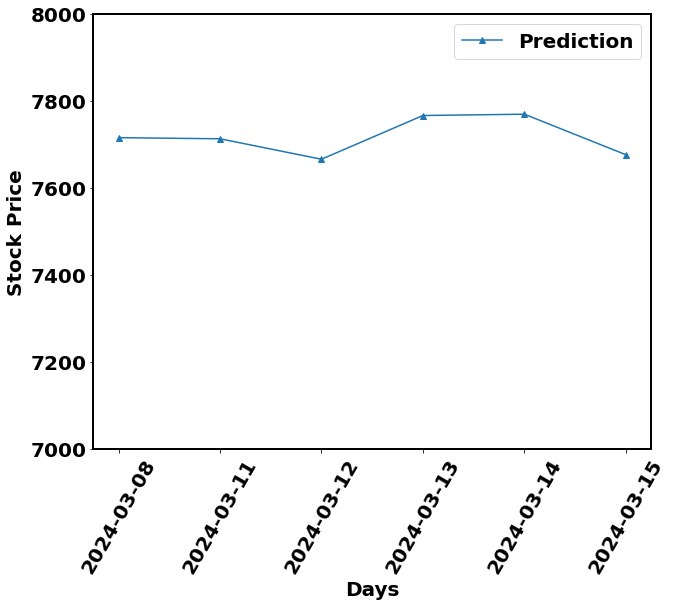

In [313]:
plt.figure(figsize=(10, 8))
plt.plot( y_8_15[0]*target_stdev + target_mean, label = "Prediction",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.xticks(list(range(6)), all_dates['Date'].values)
plt.xticks(rotation=60)
plt.ylim(7000, 8000) 
plt.legend()
plt.show()